## Dependencies

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo # Correct the import here
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.opt import SolverFactory
from pyomo.core import Var, Objective, Constraint
from pyomo.environ import ConstraintList
import time

## Data

In [181]:
#Read battery specification 
parametersinput = pd.read_csv('./battery_data.csv', index_col=0)
parameters = parametersinput.loc[1]

#Battery Specification [Constants]
capacity=parameters['Battery_Capacity']
charging_power_limit=parameters["Battery_Power"]
discharging_power_limit=parameters["Battery_Power"]
charging_efficiency=parameters["Battery_Charge_Efficiency"]
discharging_efficiency=parameters["Battery_Discharge_Efficiency"]

# Read load and PV profile data
testData = pd.read_csv('./profile_input.csv')

# Convert the various timeseries/profiles to numpy arrays
load1 = testData['Base_Load'].values
PV1 = testData['PV'].values
sellPrice = testData['Feed_Price'].values
buyPrice = testData['Load_Price'].values


def array_to_dict(arr):
    if not isinstance(arr, (list, np.ndarray)):
        raise ValueError("Input must be a list or NumPy array")
    
    result_dict = {}
    for idx, value in enumerate(arr):
        result_dict[idx + 1] = value
    
    return result_dict

PV1 = array_to_dict(PV1)
load1 = array_to_dict(load1)
sellPrice = array_to_dict(sellPrice)
buyPrice = array_to_dict(buyPrice)



## Optimization Modelling

In [182]:
#Environment
model = pyo.ConcreteModel()

#Sets
model.periods = pyo.Set(initialize=range(1,25,1))   #indexed by "t" for time step

#Parameters
model.loads = pyo.Param(model.periods, initialize=load1)     #load demand
model.sellP = pyo.Param(model.periods,initialize=sellPrice)  #price to discharge
model.buyP = pyo.Param(model.periods,initialize=buyPrice)    #price to charge
model.PV = pyo.Param(model.periods,initialize=PV1)           #determinsitic solar power production
model.SOC_0 = pyo.Param(model.periods,initialize=0)   #initial state of charge of battery
model.penalty_cost = pyo.Param(model.periods,initialize=10)  #penalty for not covering load demand (arbitrary, used as slack variable)

#Variables:
model.charge = pyo.Var(model.periods, bounds=(0, charging_power_limit))       #assuming no discharge in first hour
model.disch = pyo.Var(model.periods, bounds=(0, discharging_power_limit))  #assuming full discahrge to meet load in first hour
model.grid = pyo.Var(model.periods, within=NonNegativeReals)   #power bought from market
model.charge_PV = pyo.Var(model.periods, within=NonNegativeReals) #Charge from PV 
model.charge_grid = pyo.Var(model.periods, within=NonNegativeReals) #Charge bought from grid
model.disch_grid = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to grid
model.disch_load = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to load
model.PV_load = pyo.Var(model.periods, within=NonNegativeReals)     #PV power to load 
model.PV_grid  = pyo.Var(model.periods, within=NonNegativeReals)    #PV power sold to grid           




#Constraints
def charge_rule(model, t):
    return (model.charge_PV[t]+ model.charge_grid[t])*charging_efficiency  == model.charge[t]
model.charge_constraint = pyo.Constraint(model.periods, rule=charge_rule)

def disch_rule(model,t):
    return (model.disch_grid[t] + model.disch_load[t])/discharging_efficiency == model.disch[t] 
model.disch_constraint = pyo.Constraint(model.periods, rule=disch_rule)

def PV_rule(model,t):
    return model.PV_load[t] + model.PV_grid[t] + model.charge_PV[t] == model.PV[t]
    #return model.PV_load[t] + model.PV_grid[t]  == model.PV[t] # w/o battery
model.PV_constraint = pyo.Constraint(model.periods, rule=PV_rule)

def load_rule(model, t):
    return model.PV_load[t] + model.disch_load[t]+ model.grid[t] == model.loads[t]
    #return model.PV_load[t] + model.grid[t] == model.loads[t] # w/o battery
model.load_constraint = pyo.Constraint(model.periods, rule=load_rule)

def SOC_limit(model, t):
    return (0,capacity)
model.SOC = pyo.Var(model.periods,bounds=SOC_limit)

#def SOC_end(model,t):
#    tolerance = 1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
#    return model.SOC[t, max(model.periods)] >= capacity - tolerance

def state_of_charge(model, t):  
    if t == 1:
        return model.SOC[t] == model.SOC_0[t] + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t]+model.disch_load[t])
    elif 1<t<24:  
        return model.SOC[t] == model.SOC[t-1] +  model.charge_PV[t] + model.charge_grid[t]- (model.disch_grid[t]+model.disch_load[t])
    else:
        return model.SOC[t] - (model.SOC[t-1]  +  model.charge_PV[t] + model.charge_grid[t]- (model.disch_grid[t]+model.disch_load[t]))==0
model.state_of_charge_constraint = pyo.Constraint(model.periods, rule=state_of_charge)

#Objective function to minimize costs
def objective_rule(model):
    return sum((model.charge_grid[t] + model.grid[t])*model.buyP[t]*1 for t in model.periods) - sum((model.PV_grid[t] + model.disch_grid[t])*1*model.sellP[t] for t in model.periods)
    #return sum(( model.grid[t])*model.buyP[t] for t in model.periods) - sum((model.PV_grid[t])*model.sellP[t] for t in model.periods) # w/o battery
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

#solving
solver = SolverFactory('gurobi')
results = solver.solve(model, tee=True)
#results = opt.solve(model, tee=True)
model.display()
#model.pprint()
#model.Constraint.pprint()
print("Objective Value:", model.objective())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03
Read LP format model from file C:\Users\oscar\AppData\Local\Temp\tmpizy8w3ye.pyomo.lp
Reading time = 0.01 seconds
x1: 120 rows, 240 columns, 431 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 240 columns and 431 nonzeros
Model fingerprint: 0xce6c5358
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [3e+00, 6e+00]
  RHS range        [7e-03, 6e+00]
Presolve removed 54 rows and 129 columns
Presolve time: 0.00s
Presolved: 66 rows, 111 columns, 203 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2906926e-01   9.834601e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 3
     

## Plotting

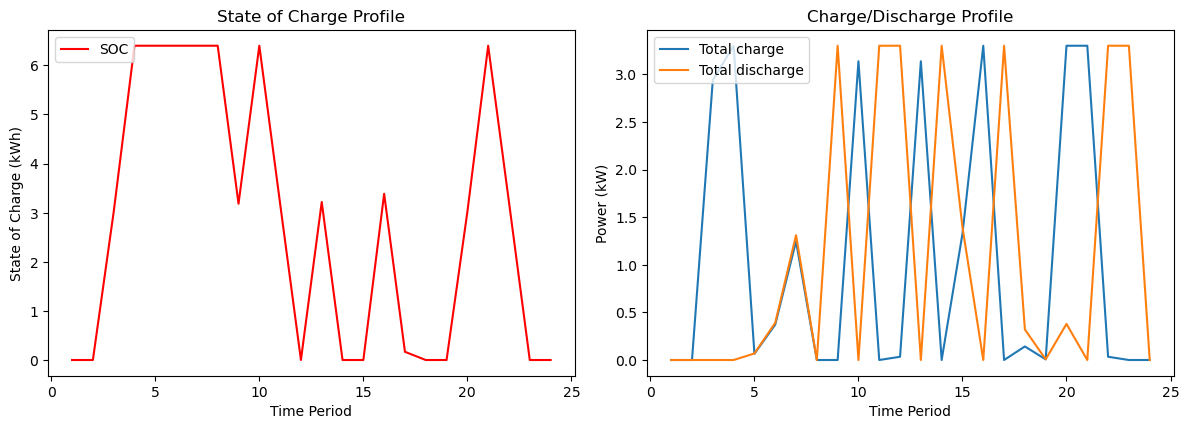

In [183]:
import matplotlib.pyplot as plt

# Extract variable values
PV_values = [pyo.value(model.PV_grid[t] + model.PV_load[t] + model.charge_PV[t]) for t in model.periods]
charge_values = [pyo.value(model.charge[t]) for t in model.periods]
disc_values = [pyo.value(model.disch[t]) for t in model.periods]
load_values = [pyo.value(model.loads[t]) for t in model.periods]
SOC_values = [pyo.value(model.SOC[t]) for t in model.periods]



# Create time periods
time_periods = list(model.periods)

# Create subplots for PV, charge, discharge, and SOC
plt.figure(figsize=(12, 8))

# Plot charge and discharge
plt.subplot(2, 2, 2)
plt.plot(time_periods, charge_values, label='Total charge')
plt.plot(time_periods, disc_values, label='Total discharge')
plt.xlabel('Time Period')
plt.ylabel('Power (kW)')
plt.legend(loc='upper left')
plt.title('Charge/Discharge Profile')

# Plot SOC
plt.subplot(2, 2, 1)
plt.plot(time_periods, SOC_values, label='SOC', color='r')
plt.xlabel('Time Period')
plt.ylabel('State of Charge (kWh)')
plt.legend(loc='upper left')
plt.title('State of Charge Profile')


plt.tight_layout()
plt.show()


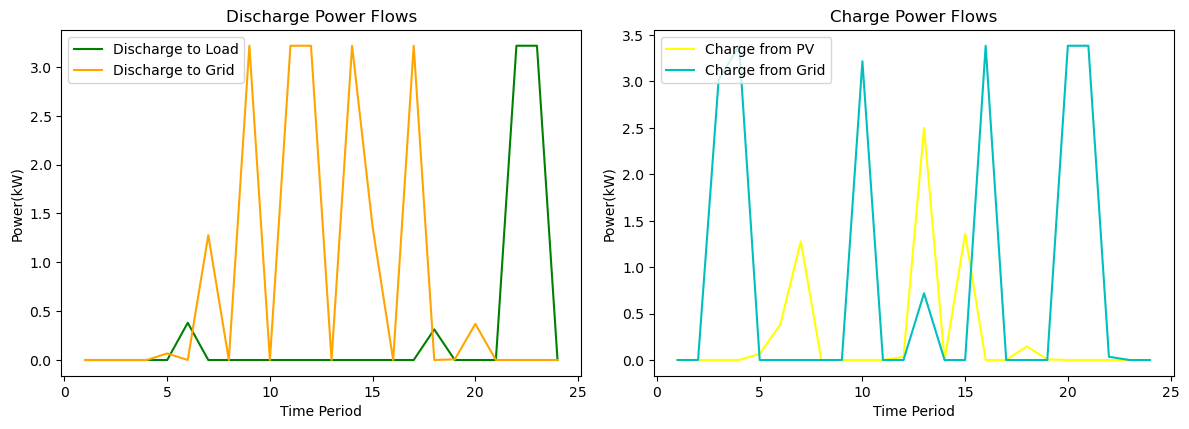

In [184]:
charge_PV=[pyo.value(model.charge_PV[t]) for t in model.periods]
charge_grid=[pyo.value(model.charge_grid[t]) for t in model.periods]
disch_load=[pyo.value(model.disch_load[t]) for t in model.periods]
disch_grid= [pyo.value(model.disch_grid[t]) for t in model.periods]
PV_grid = [pyo.value(model.PV_grid[t]) for t in model.periods]
PV_load=[pyo.value(model.PV_load[t]) for t in model.periods]

time_periods = list(model.periods)

# Create subplots for PV, charge, discharge
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.plot(time_periods, disch_load, label='Discharge to Load', color='g')
plt.plot(time_periods, disch_grid, label='Discharge to Grid', color='orange')
plt.xlabel('Time Period')
plt.ylabel('Power(kW)')
plt.legend(loc='upper left')
plt.title('Discharge Power Flows')

plt.subplot(2,2,2)
plt.plot(time_periods, charge_PV, label='Charge from PV', color='yellow')
plt.plot(time_periods, charge_grid, label='Charge from Grid', color='c')
plt.xlabel('Time Period')
plt.ylabel('Power(kW)')
plt.legend(loc='upper left')
plt.title('Charge Power Flows')


plt.tight_layout()
plt.show()

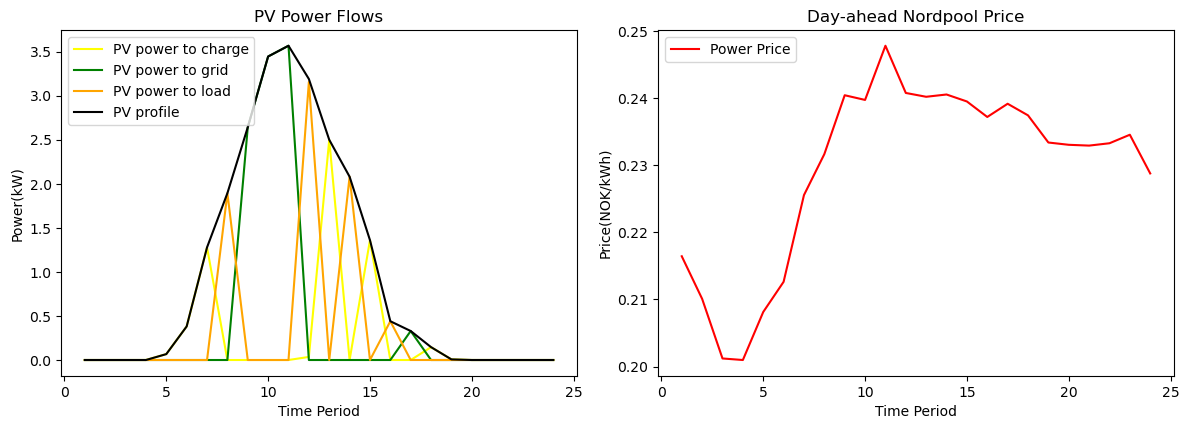

In [191]:
PV_grid = [pyo.value(model.PV_grid[t]) for t in model.periods]
PV_load=[pyo.value(model.PV_load[t]) for t in model.periods]
price_values=[pyo.value(model.sellP[t]) for t in model.periods]

time_periods = list(model.periods)

# Create subplots for PV power flows and power price
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.plot(time_periods, charge_PV, label='PV power to charge', color='yellow')
plt.plot(time_periods, PV_grid, label='PV power to grid', color='g')
plt.plot(time_periods, PV_load, label='PV power to load', color='orange')
plt.plot(time_periods, PV_values, label='PV profile', color='black')
plt.xlabel('Time Period')
plt.ylabel('Power(kW)')
plt.legend(loc='upper left')
plt.title('PV Power Flows')

plt.subplot(2,2,2)
plt.plot(time_periods, price_values, label='Power Price', color='r')
plt.xlabel('Time Period')
plt.ylabel('Price(NOK/kWh)')
plt.legend(loc='upper left')
plt.title('Day-ahead Nordpool Price')

plt.tight_layout()
plt.show()

[0.0, 0.0, 2.94, 3.3, 0.06532500000000001, 0.371475, 1.24605, 0.0, 0.0, 3.1370624999999994, 0.0, 0.03412499999999841, 3.1370624999999994, 0.0, 1.326, 3.3, 0.0, 0.14234999999999998, 0.006825, 3.3, 3.3, 0.03412499999999841, 0.0, 0.0]


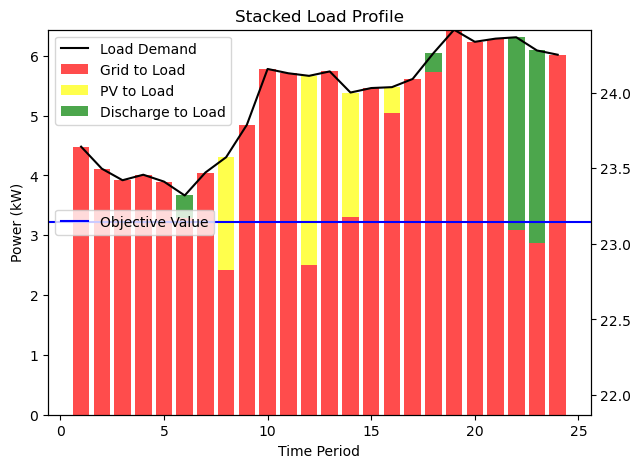

[4.481, 4.113, 3.92, 4.012, 3.897, 3.284, 4.049, 2.412, 4.847, 5.78, 5.708, 2.5109999999999983, 5.739, 3.306, 5.461, 5.036, 5.613, 5.729884615384615, 6.436, 6.234, 6.287, 3.0925000000000002, 2.871500000000001, 6.018]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.893, 0.0, 0.0, 0.0, 3.1540000000000017, 0.0, 2.08, 0.0, 0.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the Pyomo model
pv_values = [model.PV_load[t]() for t in model.periods]
load_penalty_values = [model.grid[t]() for t in model.periods]
load_demand_values = [model.loads[t] for t in model.periods]
discharge_values = [model.disch_load[t]() for t in model.periods]

time_periods = list(model.periods)

# Create a stacked bar chart

fig, ax1= plt.subplots(figsize=(7, 5))

# Plot the grid to load imports
ax1.bar(time_periods, load_penalty_values, label='Grid to Load', alpha=0.7, color='red')

# Plot the PV power
ax1.bar(time_periods, pv_values, bottom=np.array(load_penalty_values), label='PV to Load', alpha=0.7, color='yellow')

# Plot the discharge power
ax1.bar(time_periods, discharge_values, bottom=np.array(pv_values) + np.array(load_penalty_values), label='Discharge to Load', alpha=0.7, color='green')

# Plot the load demand as a curve
ax1.plot(time_periods, load_demand_values, label='Load Demand', color='black')

ax2=ax1.twinx()

ax2.axhline(y=model.objective(), color='blue', linestyle='-', label='Objective Value')
ax2.legend(loc='center left')

# Set labels and legend
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Stacked Load Profile')
ax1.legend()

# Show the plot
plt.show()
print(load_penalty_values)
print(pv_values)

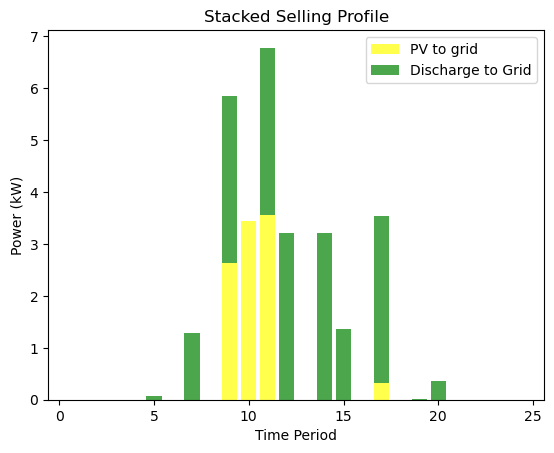

In [187]:
# Extract values from the Pyomo model
pv_grid_values = [model.PV_grid[t]() for t in model.periods]

discharge_grid_values = [model.disch_grid[t]() for t in model.periods]

# Create an array for the time periods
time_periods = list(model.periods)

# Create a stacked bar chart
fig, ax = plt.subplots()

# Plot the PV power to grid
ax.bar(time_periods, pv_grid_values, label='PV to grid', alpha=0.7, color='yellow')

# Plot the discharge power to grid
ax.bar(time_periods, discharge_grid_values, bottom=np.array(pv_grid_values), label='Discharge to Grid', alpha=0.7, color='green')



# Set labels and legend
ax.set_xlabel('Time Period')
ax.set_ylabel('Power (kW)')
ax.set_title('Stacked Selling Profile')
ax.legend()

# Show the plot
plt.show()


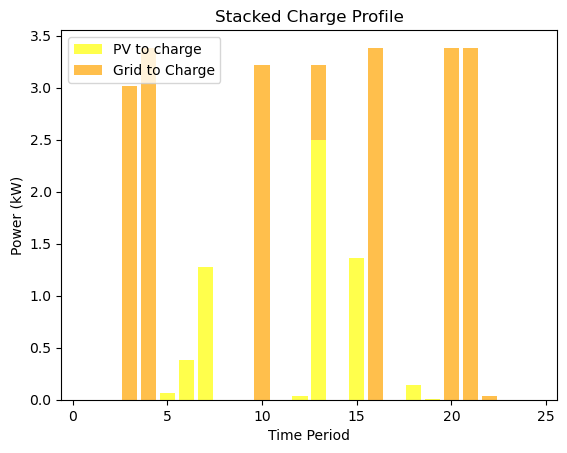

In [188]:
# Extract values from the Pyomo model
charge_grid_values = [model.charge_grid[t]() for t in model.periods]

charge_PV_values = [model.charge_PV[t]() for t in model.periods]

# Create an array for the time periods
time_periods = list(model.periods)

# Create a stacked bar chart
fig, ax = plt.subplots()

# Plot the PV power to charge
ax.bar(time_periods, charge_PV_values, label='PV to charge', alpha=0.7, color='yellow')

# Plot the grid power to charge
ax.bar(time_periods, charge_grid_values, bottom=np.array(charge_PV_values), label='Grid to Charge', alpha=0.7, color='orange')



# Set labels and legend
ax.set_xlabel('Time Period')
ax.set_ylabel('Power (kW)')
ax.set_title('Stacked Charge Profile')
ax.legend()

# Show the plot
plt.show()

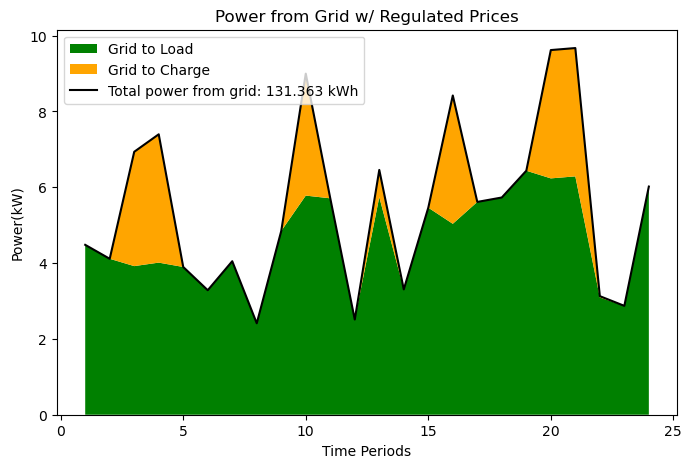

29.148730769230767


In [189]:
load_penalty_values = [pyo.value(model.grid[t]) for t in model.periods]
charge_grid= [pyo.value(model.charge_grid[t]) for t in model.periods]
total=[pyo.value(model.charge_grid[t] + model.grid[t]) for t in model.periods]

time_periods = list(model.periods)


plt.figure(figsize=(8, 5))

# Create the stacked plot for Grid imports
colors = ['g', 'orange']
plt.stackplot(time_periods, load_penalty_values, charge_grid, labels=['Grid to Load', 'Grid to Charge'], colors=colors)
plt.plot(time_periods, total, label=f'Total power from grid: {round(sum(model.charge_grid[t].value + model.grid[t].value for t in model.periods),3)} kWh', color='black')
# Add labels and legend
plt.xlabel('Time Periods')
plt.ylabel('Power(kW)')
plt.title('Power from Grid w/ Regulated Prices')
plt.legend(loc='upper left')


plt.show()

print(sum(model.PV_grid[t].value + model.disch_grid[t].value for t in model.periods))

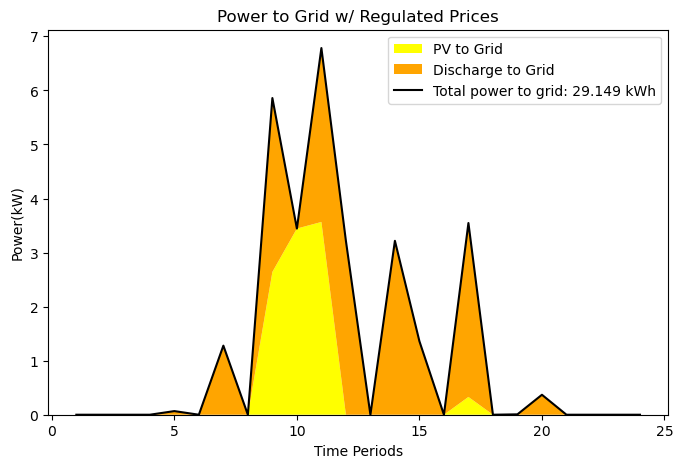

In [190]:
PV_supply_values = [pyo.value(model.PV_grid[t]) for t in model.periods]
Disch_supply= [pyo.value(model.disch_grid[t]) for t in model.periods]
total=[pyo.value(model.disch_grid[t] + model.PV_grid[t]) for t in model.periods]
time_periods = list(model.periods)

# Create subplots for PV, charge, discharge, load, and SOC
plt.figure(figsize=(8, 5))

# Create the stacked plot for grid supply 
colors = ['yellow', '#FFA500']
plt.stackplot(time_periods, PV_supply_values, Disch_supply, labels=['PV to Grid', 'Discharge to Grid'], colors=colors)
plt.plot(time_periods, total, label=f'Total power to grid: {round(sum(model.disch_grid[t].value + model.PV_grid[t].value for t in model.periods),3)} kWh', color='black')
# Add labels and legend
plt.xlabel('Time Periods')
plt.ylabel('Power(kW)')
plt.title('Power to Grid w/ Regulated Prices')
plt.legend(loc='upper right')


plt.show()
